In [35]:
from soan_master.whatsapp import helper      # Helper to prepare the data
from soan_master.whatsapp import general     # General statistics

from soan_master.whatsapp import tf_idf      # To calculate TF-IDF 
# Dependency: pip install pillow (for PIL: Python Image Library)

from soan_master.whatsapp import soan_emoji  # To analyze emoji use # Dependency: pip install emoji regex seaborn

from soan_master.whatsapp import topic       # Topic modelling and summarization # Dependency: pip install sklearn
# Dependency: "pip install pattern"
# "pattern3" is not same as "pattern" and "pattern" does not come for Python-3 (as of 20190717).

from soan_master.whatsapp import sentiment   # Sentiment Analysis
from soan_master.whatsapp import soan_wordcloud   # Create Word Clouds # Dependency: pip install wordcloud palettable

from soan_master.colors   import colors      # Frequent Color Visualization

%matplotlib inline

In [36]:
df = helper.import_data('WhatsApp Chat with FSADM Team.txt')

In [37]:
df = helper.preprocess_data(df)

In [39]:
#df.to_csv("WhatsApp Chat with FSADM Team.csv", index=False, encoding = 'utf-8')

## <a name="emoji">4. Emoji Analysis</a> 
[Back to Table of Contents](#table)

These analysis are based on the Emojis used in each message. Below you can find the following:
* Unique Emoji per user
* Commonly used Emoji per user
* Highly correlated Emoji per user

#### <a name="emoji-prepare">4.1 Prepare Data</a> 
[Back to Table of Contents](#table)

The data needs to be prepared as follows:
* Three new columns are created:
    * *Emoji* contains all emojis in a message
    * *Emoji_Counts* counts the number of emojis in a message
    * *Different_Emojis* extracts them in a list for handling purposes
* *counts* is a dictionary of dictionaries containing the count of each emoji per user
* *unique_emoji* is a dict of dicts containing a uniqueness score of each emoji per user compared to other users

In [5]:
# https://github.com/pandas-dev/pandas/issues/17892
temp = df[['index', 'Message_Raw', 'User', 'Message_Clean', 'Message_Only_Text']].copy()
temp = soan_emoji.prepare_data(temp)

# Count all emojis
counts = soan_emoji.count_emojis(temp, non_unicode=True)

# Get unique emojis
list_of_words = [word for user in counts for word in counts[user]]
unique_emoji = soan_emoji.get_unique_emojis(temp, counts, list_of_words)
del temp

soan_master\whatsapp\soan_emoji.py:131: RuntimeWarning: invalid value encountered in double_scalars
  unique_dict[user][word] = tf_idf_user / (tf_idf_all - tf_idf_user)


#### <a name="emoji-stats">4.2 Unique and Common Emoji</a> 
[Back to Table of Contents](#table)

Below you can find the most unique emojis according to the TF-IDF and Unique formulas that were used previously: 

** TF-IDF **

$ TFIDF_i = \frac{{t_{ij} + 1}}{w_i + 1} \times \log{\frac{m}{\sum_{i=1}^{n} t_j}} $  
$w_i = $ Number of words texted by $i$  
$t_{ij} = $ Number of times a specific emoji $j$ was said by $i$  
$m = $ Number of all messages  

** Unique Emoji **  
  
$ Unique_i = \frac{TFIDF_i}{\sum\limits_{j, j \neq i}^n TFIDF_i} $

I purposefully based it on the number of words and messages in total and only changed *t* to the number of times emoji was said

In [7]:
soan_emoji.print_stats(unique_emoji, counts)

#############################
### Unique Emoji (TF-IDF) ###
#############################
()
+91 97313 95151
('BD', nan)
(':/', nan)
('8-p', nan)
()
+91 95383 77413
('BD', nan)
(':/', nan)
('8-p', nan)
()
Jsrini
('BD', nan)
(':/', nan)
('8-p', nan)
()
+91 78299 06193
('BD', nan)
(':/', nan)
('8-p', nan)
()
+91 88610 07050
('BD', nan)
(':/', nan)
('8-p', nan)
()
+91 98455 44538
('BD', nan)
(':/', nan)
('8-p', nan)
()
+91 96730 06577
('BD', nan)
(':/', nan)
('8-p', nan)
()
Pk
('BD', nan)
(':/', nan)
('8-p', nan)
()
Bala
('BD', nan)
(':/', nan)
('8-p', nan)
()
+91 98906 90583
('BD', nan)
(':/', nan)
('8-p', nan)
()
Rajneesh
('BD', nan)
(':/', nan)
('8-p', nan)
()
Kasturi
('BD', nan)
(':/', nan)
('8-p', nan)
()
+91 97654 10589
('BD', nan)
(':/', nan)
('8-p', nan)
()
+91 78290 04757
('BD', nan)
(':/', nan)
('8-p', nan)
()
+91 72590 26741
('BD', nan)
(':/', nan)
('8-p', nan)
()
+91 91582 24760
('BD', nan)
(':/', nan)
('8-p', nan)
()
Somesh
('BD', nan)
(':/', nan)
('8-p', nan)
()
+91 97666 22

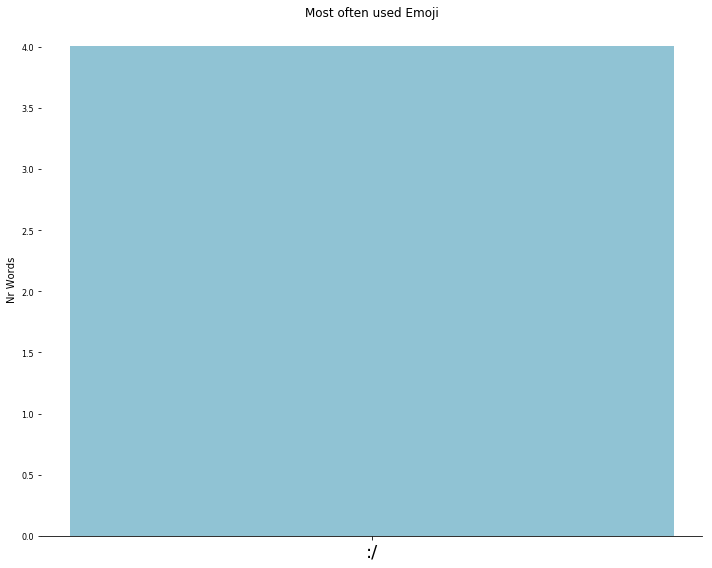

In [10]:
soan_emoji.plot_counts(counts, user = '+91 96527 79555')

#### <a name="emoji-corr">4.3 Correlation Matrix</a> 
[Back to Table of Contents](#table)

Below you find a correlation matrix of the 15 most often used emoji by a single user. The reasoning for only taking 15 emojis is that otherwise the matrix simply becomes too big. 

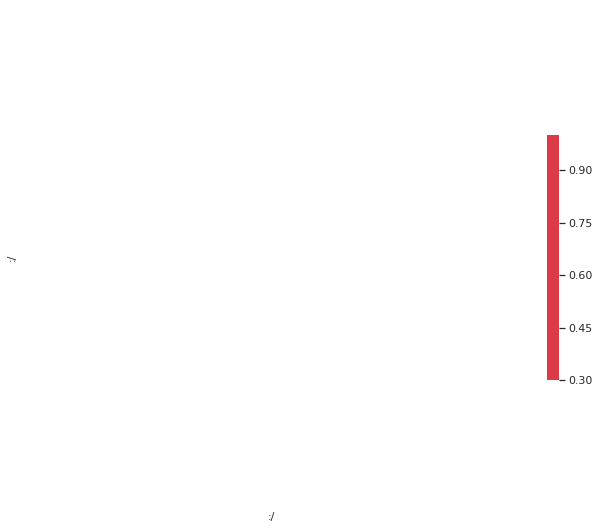

In [11]:
soan_emoji.plot_corr_matrix(df, '+91 96527 79555', list_of_words, counts)

## <a name="topic">5. Topic Modelling</a> 
[Back to Table of Contents](#table)

#### <a name="topic-prepare">5.1 Prepare Data</a> 
[Back to Table of Contents](#table)

The data is prepared as follows:
The *pattern* is used as that is one of the few (sort of) working Dutch NLP-processors for python. There is generally little available with regards to Dutch processors. Since I want to extract topics translating text did not seem like the right way to go. So, using *pattern* I used the following functions where necessary:
* Lemmatization
* Singularize
* Predicative

Unfortunately, stemming was not an option since the Snowball stemmer from NLTK makes too many mistakes to be used. 

*NOTE*: These analyses are for the purpose of getting insights into whatsapp data. I did not spend much time optimizing algorithms for the simple reason that they already give good results out-of-the-box. Moreover, optimizing my results is likely not generalizable to your data as you are quick to overfit with such limited data.

*NOTE2*: # Make sure to download the version for python 3+:
* https://github.com/clips/pattern/tree/development
* git clone -b development https://github.com/clips/pattern
* cd pattern
* python setup.py install

In [12]:
df['Message_Prepared'] = df.apply(lambda row: topic.prepare_text_nl(row), 1)

#### <a name="topic-lda">5.2 LDA </a> 
[Back to Table of Contents](#table)

There is an abundance of methods with regards to topic modelling. Two, however, seem to be the most used: LDA and NMF. Sklearn has an implementation of both LDA and NMF which is why I used that. It should be noted that Gensim is also an extremely good package when it comes to NLP. I will be using Gensim later below for a different application. 

In [14]:
#topic.topics(df, model='lda', stopwords='stopwords_dutch.txt')
topic.topics(df, model='lda')

################
### Rajneesh ###
################


Topics in lda model:
Topic #0: to of see team and leadership soom
Topic #1: zijn with soom in team narahari to
Topic #2: every the we zijn new ar in
Topic #3: your to zijn leadership new work with
Topic #4: day have happy birthday you return great
()
#######################
### +91 96527 79555 ###
#######################


Topics in lda model:
Topic #0: hyderabad hall town moor and ahead of
Topic #1: nice town hall sez hyderabad one good
Topic #2: congrat good team one sez alok happy
Topic #3: the moor many day happy return of
Topic #4: in this zijn many message your you
()
#######################
### +91 98906 90583 ###
#######################


Topics in lda model:
Topic #0: the to and your birthday happy imgwajpg
Topic #1: happy birthday congratulation yogesh imgwajpg your and
Topic #2: yogesh the to happy congratulation birthday your
Topic #3: the fiil imgwajpg happy and your to
Topic #4: fiil attached to imgwajpg the your yogesh

#### <a name="topic-nmf">5.3 NMF </a> 
[Back to Table of Contents](#table)

An application of the NMF model used for topic modelling. 

In [15]:
#topic.topics(df, model='nmf', stopwords='stopwords_dutch.txt')
topic.topics(df, model='nmf')

################
### Rajneesh ###
################


Topics in nmf model:
Topic #0: to see good team work soom and
Topic #1: day happy have birthday of return many
Topic #2: every zijn the we good narahari with
Topic #3: you narahari in with new leadership to
Topic #4: this your zijn new in ar we
()
#######################
### +91 96527 79555 ###
#######################


Topics in nmf model:
Topic #0: day many happy the moor of return
Topic #1: good one zijn moor alok and congrat
Topic #2: congrat team alok zijn moor and congratulation
Topic #3: zijn this message deleted and in the
Topic #4: town hall hyderabad sez zijn message alok
()
#######################
### +91 98906 90583 ###
#######################


Topics in nmf model:
Topic #0: happy birthday yogesh your to the imgwajpg
Topic #1: congratulation your yogesh to the imgwajpg happy
Topic #2: the to and your yogesh imgwajpg happy
Topic #3: imgwajpg fiil attached your yogesh to the
Topic #4: yogesh your to the imgwajpg happy fiil

IndexError: index 4 is out of bounds for axis 1 with size 4

## <a name="sentiment">6. Sentiment</a> 
[Back to Table of Contents](#table)

#### <a name="sentiment-prepare">6.1 Prepare Data</a> 
[Back to Table of Contents](#table)

Fortunately, in order to extract sentiment from a Dutch message you can extract the score (-1 being negative and 1 being positive) easily using the pattern package. Below I extract the sentiment as a new column which is needed for further analysis. 

In [16]:
from pattern.nl import sentiment  as sentiment_nl
df['Sentiment'] = df.apply(lambda row: sentiment_nl(row.Message_Clean)[0], 1)

#### <a name="sentiment-average">6.2 Average Sentiment Per User</a> 
[Back to Table of Contents](#table)

Prints the average sentiment per user to get an indication of positivity of that user. 

*NOTE*: THIS ONLY WORKS FOR DUTCH!

In [17]:
sentiment.print_avg_sentiment(df)

			#######################
			## Average Sentiment ##
			#######################
Rajneesh:                     		0.406
+91 96527 79555:              		0.289
+91 98906 90583:              		0.154
Pk:                           		0.317
+91 73810 91277:              		0.28
Bala:                         		0.535
+91 99002 12876:              		0.21
+91 97654 10589:              		0.27
Kasturi:                      		0.321
+91 78299 06193:              		0.151
+91 96730 06577:              		0.449
+91 95383 77413:              		0.179
+91 98455 44538:              		0.145
+91 97666 22928:              		0.134
+91 77690 27474:              		0.159
Naveen:                       		0.042
+91 97313 95151:              		0.122
+91 72590 26741:              		0.056
+91 78290 04757:              		0.147
Jsrini:                       		0.164
+91 91582 24760:              		0.083
+91 88610 07050:              		0.17
Somesh:                       		0.0





#### <a name="sentiment-plot">6.3 Plot Sentiment</a> 
[Back to Table of Contents](#table)

Below you can see a plot of how positive the messages are over time. The y-axis works as follows, a happy smiley indicates a score of 1 (max value) meaning a positive message and a sad smiley indicates a score of -1 (min value) meaning a negative message. 

C:\Users\ashish.jain50\AppData\Local\Continuum\anaconda3\envs\py_2716\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


IndexError: list index out of range

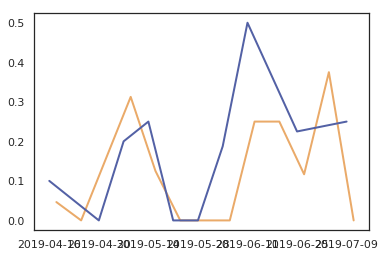

In [18]:
sentiment.plot_sentiment(df, colors=['#EAAA69','#5361A5'], savefig=False)

## <a name="cloud">7. Word Clouds</a> 
[Back to Table of Contents](#table)

#### <a name="cloud-prepare">7.1 Prepare Data</a> 
[Back to Table of Contents](#table)

In [19]:
# Counts words and create dictionary of words with counts
counts = tf_idf.count_words_per_user(df,sentence_column="Message_Only_Text",user_column="User")
counts = tf_idf.remove_stopwords(counts, column="Word")

#### <a name="cloud-mask">7.2 Masked Word Cloud</a> 
[Back to Table of Contents](#table)

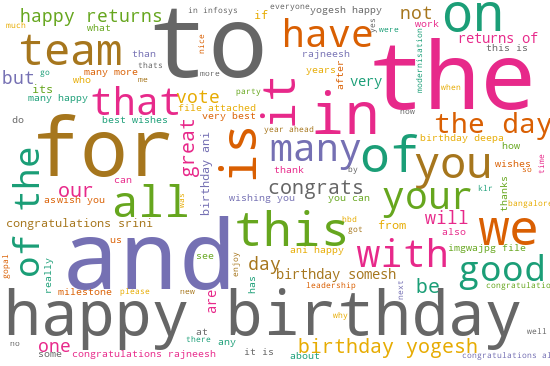

In [23]:
soan_wordcloud.create_wordcloud(df.Message_Only_Text, mask = 'histogram.jpg', 
                           stopwords='stopwords_dutch.txt', random_state=42, 
                           max_words=1000, max_font_size=50, scale=2, 
                           normalize_plurals=False, relative_scaling = 0.5)

#### <a name="cloud-sentiment">7.3 Sentiment-based Word Cloud</a> 
[Back to Table of Contents](#table)

*NOTE*: ONLY WORKS FOR DUTCH

In [26]:
# Choose which user you want to see the word cloud for
positive, negative = soan_wordcloud.extract_sentiment_count(counts, user = "Rajneesh")

##### Positive Words

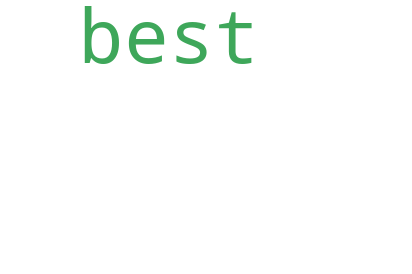

In [29]:
soan_wordcloud.create_wordcloud(data=positive, cmap='Greens', mask='histogram.jpg', 
                    stopwords='stopwords_dutch.txt', random_state=42, max_words=1000, 
                    max_font_size=50, scale=1.5, normalize_plurals=False, relative_scaling=0.5)

##### Negative Words

In [30]:
soan_wordcloud.create_wordcloud(data=negative, cmap='Reds', mask='histogram.jpg', 
                    stopwords='stopwords_dutch.txt', random_state=42, max_words=1000, 
                    max_font_size=50, scale=1.5, normalize_plurals=False, relative_scaling=0.5)

ValueError: We need at least 1 word to plot a word cloud, got 0.

## <a name="color">8. Picture Analysis</a> 
[Back to Table of Contents](#table)

NOTE: This is not part of the whatsapp data. For this chapter to work, you'll need to put at least 1 image in the folder 'Images/' or create a path of your own. It is set to not run automatically since this is merely an extra feature. Set run_colors to True if you want to run the script. 

#### <a name="color-get">8.1 Extract Frequent Colors (k-Means)</a> 
[Back to Table of Contents](#table)

In [31]:
import os
import pickle

Below is the code to retrieve and dump the top 5 most frequent colors in an image using k-Means. 
It works as follows, each pixel in an image has its own color. That color of each pixel in an image is then extracted in an rgb format. This allows each pixel to have an x (r), y (g) and z (b) coordinate. After extracting all colors of each pixel, k-Means (with k=5) is then used to cluster the points into 5 colors. For each cluster the mediod is calculated and used as a representative of that cluster. Thus, you get top 5 colors for each image. 

In [32]:
extract_colors = False

if extract_colors:
    # Get Top 5 Frequent Colors
    path = 'Images/'
    all_colors = [colors.get_common_colors(path + i) for i in os.listdir(path)]

    # Save colors
    with open('colors.pkl', 'wb') as f:
        pickle.dump(all_colors, f)

#### <a name="color-plot">8.2 Plot Frequent Colors</a> 
[Back to Table of Contents](#table)

After getting the top 5 colors for each picture, they are counted and then displayed below in a histogram. The histogram is in a circular shape where larger/bigger/higher bars indicate colors that are more frequent in the set of pictures. There is a version of the histogram that only shows bars and one that shows a smoothened histogram to be more visually pleasing. 

In [34]:
colors.plot_color('colors.pkl', smoothen=False, savefig=False)

ValueError: unsupported pickle protocol: 3

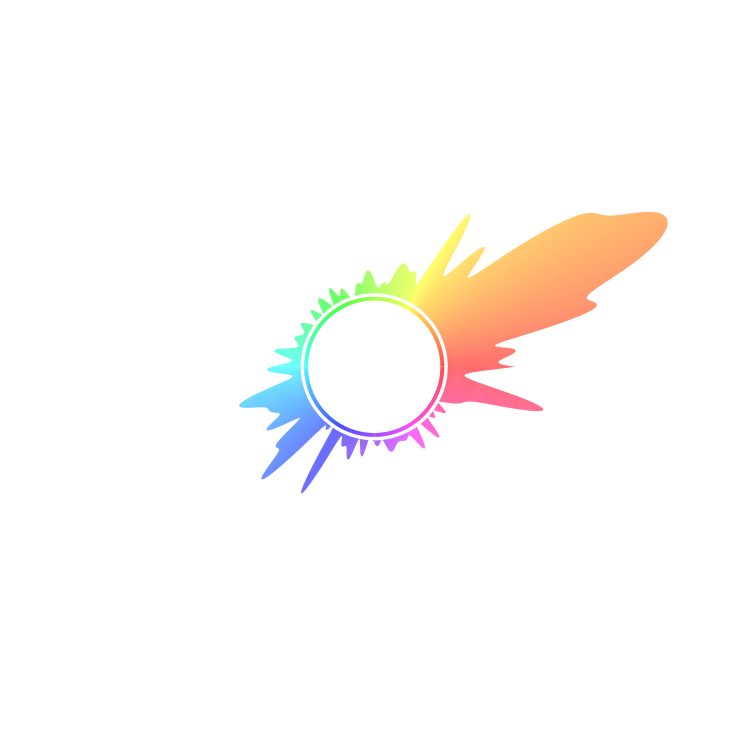

In [35]:
colors.plot_color('colors.pkl', smoothen=True, savefig=False)